# MLP Exercise - fantasy name generation

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from src.layers import Linear, BatchNorm1d, Tanh
from tqdm import tqdm
import time
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Get the datasets

import kagglehub

# Download latest version
path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")

print("Path to dataset files:", path)

d:\dev\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [3]:
# clean data, normalize strings 
import glob
import pandas as pd 
allcsvs = []
for f in glob.glob(path+"/*.csv"):#  + ["./names_clean.csv"]:
    df = pd.read_csv(f, header=None)
    series = (df[0].str.normalize('NFKD')
                   .str.encode('ascii', errors='ignore')
                   .str.decode('utf-8')
                   .str.lower()
                   .str.replace(r'[^\w\s]', '')
                   .str.replace('/', '')
                   .str.replace('(', '')
                   .str.replace(')', '')
                   .str.strip()
                   
                   )

    allcsvs.append(series)

# Adding names from names_clean.csv
words = pd.concat(allcsvs).to_list()


In [4]:
print(len(words))
words[:8]

22523


['mai', 'ba', 'binh', 'chi', 'cong', 'cuong', 'ha', 'hien']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: "'", 3: '-', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 0: '.'}
30


In [6]:
def encode(s):
    """
    Encodes a string `s` into a list of integers using the `stoi` mapping.
    """
    return [stoi[c] for c in s]

def decode(t):
    """
    Decodes a tensor or list `t` of integers into a string using the `itos` mapping.
    """
    if hasattr(t, "tolist"):
        t = t.tolist()
    return ''.join([itos[i] for i in t])



In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Helper function 1: Pad a string to block_size from the start
def pad_start(word_chars, block_size):
    """
    Pad a word (as list of token IDs) to block_size from the start with padding tokens (0).
    
    Args:
        word_chars: List of token IDs representing the word
        block_size: Target length
    
    Returns:
        Padded list of length block_size
    """
    padding_needed = block_size - len(word_chars)
    if padding_needed > 0:
        return [0] * padding_needed + word_chars
    return word_chars

# Helper function 2: Pad a word to block_size from the end (if shorter)
def pad_end(word_chars, block_size):
    """
    Pad a word (as list of token IDs) to block_size from the end with padding tokens (0).
    
    Args:
        word_chars: List of token IDs representing the word
        block_size: Target length
    
    Returns:
        Padded list of length block_size
    """
    padding_needed = block_size - len(word_chars)
    if padding_needed > 0:
        return word_chars + [0] * padding_needed
    return word_chars[:block_size]  # Truncate if longer

# Helper function 3: Build block_size sequences from a word starting at anchor position
def build_block_sized_sequences(word_chars, anchor_pos, block_size):
    """
    Build exactly block_size sequences starting from anchor position.
    Each sequence starts with a single '.' token, then word characters.
    
    For anchor_pos=0 with word "abc" and block_size=8:
        Sequence 0: ['.', 'a', ...] -> 'b'  (single '.' + word[0] + padding if needed)
        Sequence 1: ['.', 'a', 'b', ...] -> 'c'  (single '.' + word[0:2] + padding)
        Sequence 2: ['.', 'a', 'b', 'c', ...] -> '.'  (single '.' + word[0:3] + padding)
        Sequence 3-7: ['.', 'a', 'b', 'c', '.', ...] -> padding (if word ends)
    
    For anchor_pos=1 with word "abcdefghijk" and block_size=8:
        Sequence 0: ['.', 'a', 'b', ...] -> 'c'  (single '.' + word[0:2] + padding)
        Sequence 1: ['.', 'a', 'b', 'c', ...] -> 'd'  (single '.' + word[0:3] + padding)
        ...
        Sequence 7: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g'] -> 'h'  (single '.' + word[0:7])
    
    Args:
        word_chars: List of token IDs representing the word (with '.' at end)
        anchor_pos: Starting position in the word (0-indexed)
        block_size: Number of sequences to generate (each of length block_size)
    
    Returns:
        X: List of block_size sequences, each of length block_size
        Y: List of block_size target tokens
    """
    X = []
    Y = []
    
    # Get the '.' token ID (should be stoi['.'])
    dot_token = stoi['.']
    
    # Build block_size sequences
    for i in range(block_size):
        # Each sequence starts with a single '.' token
        context = [dot_token]
        
        # Determine how many word characters to include
        # For anchor_pos=0: include word[0:i+1]
        # For anchor_pos=1: include word[0:anchor_pos+i+1] (to include chars before anchor)
        
        if anchor_pos == 0:
            # Simple case: start from beginning
            chars_to_add = word_chars[0:min(i+1, len(word_chars))]
        else:
            # For anchor_pos > 0, include characters before anchor_pos
            # Sequence i needs: '.' + word[0:anchor_pos+i+1]
            end_char_idx = anchor_pos + i + 1
            chars_to_add = word_chars[0:min(end_char_idx, len(word_chars))]
        
        context.extend(chars_to_add)
        
        # Pad at the end if needed (with padding token 0, not '.')
        if len(context) < block_size:
            # Pad with padding token (0) at the end
            context.extend([0] * (block_size - len(context)))
        elif len(context) > block_size:
            # Take last block_size tokens (shouldn't happen, but safety)
            context = context[-block_size:]
        
        X.append(context)
        
        # Target: the character at position anchor_pos + i + 1
        target_pos = anchor_pos + i + 1
        if target_pos < len(word_chars):
            Y.append(word_chars[target_pos])
        else:
            # Beyond word length, predict padding token (0)
            Y.append(0)
    
    return X, Y

# Refactored build_dataset function
def build_dataset(words):
    """
    Build dataset where each sample contains exactly block_size sequences.
    Each sample is anchored at a different position in the word.
    
    For word "abcdefghijk" with block_size=8:
    - Sample 1 (anchor=0): sequences from all padding -> 'a' up to 'a'...'h' -> 'i'
    - Sample 2 (anchor=1): sequences from (7 padding + 'a') -> 'b' up to 'a'...'h' -> 'i'
    - Sample 3 (anchor=2): sequences from (6 padding + 'ab') -> 'c' up to 'b'...'i' -> 'j'
    - etc.
    
    Returns:
        X: Tensor of shape (num_samples, block_size, block_size)
        Y: Tensor of shape (num_samples, block_size)
    """
    all_samples_X = []
    all_samples_Y = []
    
    for w in words:
        # Encode the word with '.' as end token
        chars = [stoi[c] for c in w + '.']
        
        # Determine valid anchor positions
        # For anchor_pos, we need to be able to predict up to chars[anchor_pos + block_size]
        # So we need: anchor_pos + block_size < len(chars)
        # Therefore: anchor_pos < len(chars) - block_size
        
        max_anchor = len(chars) - block_size
        
        # Create samples for each valid anchor position
        for anchor_pos in range(max(0, max_anchor + 1)):
            # Create a sample starting at this anchor position
            sample_X, sample_Y = build_block_sized_sequences(chars, anchor_pos, block_size)
            all_samples_X.append(sample_X)
            all_samples_Y.append(sample_Y)
        
        # Handle words shorter than block_size
        # Create one sample starting at position 0 with padding
        if len(chars) <= block_size:
            # Pad the word to block_size from the end
            padded_chars = pad_end(chars, block_size)
            sample_X, sample_Y = build_block_sized_sequences(padded_chars, 0, block_size)
            all_samples_X.append(sample_X)
            all_samples_Y.append(sample_Y)
    
    # Convert to tensors
    X = torch.tensor(all_samples_X, device=device)  # (num_samples, block_size, block_size)
    Y = torch.tensor(all_samples_Y, device=device)  # (num_samples, block_size)
    
    print(f"X shape: {X.shape}  # (num_samples, block_size, block_size)")
    print(f"Y shape: {Y.shape}  # (num_samples, block_size)")
    print(f"Each sample contains exactly {block_size} sequences of length {block_size}")
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

def get_batch(split, batch_size):
    """
    Generate a batch of samples.
    
    Each sample is (block_size, block_size) - block_size sequences of block_size tokens each.
    Batch shape: (batch_size, block_size, block_size)
    
    Returns:
        x: (batch_size * block_size, block_size) - flattened for processing
        y: (batch_size * block_size,) - flattened targets
    """
    data_X = Xtr if split == 'train' else Xdev if split == 'dev' else Xte
    data_Y = Ytr if split == 'train' else Ydev if split == 'dev' else Yte
    
    # Generate indices on GPU to avoid CPU-GPU transfer overhead
    ix = torch.randint(len(data_X), (batch_size,), device=device)
    
    # Each sample is (block_size, block_size), batch becomes (batch_size, block_size, block_size)
    x = data_X[ix]  # (batch_size, block_size, block_size)
    y = data_Y[ix]  # (batch_size, block_size)
    
    # Reshape to process all sequences: (batch_size * block_size, block_size)
    # This allows the model to process all sequences from all samples in the batch
    B, T_seq, T_tokens = x.shape
    x = x.view(B * T_seq, T_tokens)  # (batch_size * block_size, block_size)
    y = y.view(B * T_seq)  # (batch_size * block_size,)
    
    return x, y

# Verify dataset structure
print(f"Xtr shape: {Xtr.shape}, Ytr shape: {Ytr.shape}")
print(f"✓ Dataset structure: (num_samples, block_size, block_size)")
print(f"✓ Each sample contains exactly {block_size} sequences of length {block_size}\n")

# Show first sample's sequences
print("Example: First sample's sequences (anchor position 0):")
first_sample_X = Xtr[0]  # (block_size, block_size)
first_sample_Y = Ytr[0]  # (block_size,)
for i in range(min(8, first_sample_X.shape[0])):
    x_seq = first_sample_X[i].cpu().tolist()
    y_token = first_sample_Y[i].item()
    x_str = ''.join(['.' if tok == 0 else itos[tok] for tok in x_seq])
    y_str = '.' if y_token == 0 else itos[y_token]
    print(f"  [{i:2d}] {x_str:20s} -> {y_str}")

# Test batch
x_batch, y_batch = get_batch('train', 2)
print(f"\nBatch shapes after get_batch:")
print(f"  x_batch: {x_batch.shape}  # (batch_size * block_size, block_size)")
print(f"  y_batch: {y_batch.shape}  # (batch_size * block_size,)")
print(f"\n✓ Each batch contains {2} samples, each with {block_size} sequences")
print(f"✓ All sequences have T={block_size} tokens - attention will work correctly!")
print(f"\nFirst few sequences in batch:")
for i in range(min(5, len(x_batch))):
    x_str = ''.join(['.' if tok == 0 else itos[tok] for tok in x_batch[i].cpu().tolist()])
    y_str = '.' if y_batch[i].item() == 0 else itos[y_batch[i].item()]
    print(f"  [{i:2d}] {x_str:20s} -> {y_str}")

X shape: torch.Size([34632, 8, 8])  # (num_samples, block_size, block_size)
Y shape: torch.Size([34632, 8])  # (num_samples, block_size)
Each sample contains exactly 8 sequences of length 8
X shape: torch.Size([4438, 8, 8])  # (num_samples, block_size, block_size)
Y shape: torch.Size([4438, 8])  # (num_samples, block_size)
Each sample contains exactly 8 sequences of length 8
X shape: torch.Size([4465, 8, 8])  # (num_samples, block_size, block_size)
Y shape: torch.Size([4465, 8])  # (num_samples, block_size)
Each sample contains exactly 8 sequences of length 8
Xtr shape: torch.Size([34632, 8, 8]), Ytr shape: torch.Size([34632, 8])
✓ Dataset structure: (num_samples, block_size, block_size)
✓ Each sample contains exactly 8 sequences of length 8

Example: First sample's sequences (anchor position 0):
  [ 0] .......f             -> r
  [ 1] ......fr             -> i
  [ 2] .....fri             -> c
  [ 3] ....fric             -> i
  [ 4] ...frici             -> s
  [ 5] ..fricis            

In [23]:
# Export dataset to JSON for inspection
import json

def export_dataset_to_json(X, Y, words_list, output_file, max_words=50):
    """
    Export dataset to a structured JSON file for inspection.
    
    Args:
        X: Tensor of shape (num_words, max_sequences, block_size)
        Y: Tensor of shape (num_words, max_sequences)
        words_list: List of original words (in same order as X/Y)
        output_file: Path to output JSON file
        max_words: Maximum number of words to export (for readability)
    """
    dataset_export = []
    
    num_words_to_export = min(max_words, len(words_list))
    
    for word_idx in range(num_words_to_export):
        word = words_list[word_idx]
        word_X = X[word_idx].cpu().tolist()  # (max_sequences, block_size)
        word_Y = Y[word_idx].cpu().tolist()  # (max_sequences,)
        
        sequences = []
        for seq_idx in range(len(word_X)):
            x_seq = word_X[seq_idx]
            y_token = word_Y[seq_idx]
            
            # Skip padding sequences
            if y_token < 0:
                continue
            
            # Convert sequence to readable format
            x_str = ''.join(['.' if tok == 0 else itos[tok] for tok in x_seq])
            y_str = itos[y_token] if y_token >= 0 else '<PAD>'
            
            sequences.append({
                "sequence_index": seq_idx,
                "input_sequence": x_str,
                "input_tokens": x_seq,
                "target_token": y_str,
                "target_token_id": int(y_token)
            })
        
        if sequences:  # Only add if word has valid sequences
            dataset_export.append({
                "word_index": word_idx,
                "original_word": word,
                "num_sequences": len(sequences),
                "sequences": sequences
            })
    
    # Write to JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump({
            "dataset_info": {
                "total_words": len(words_list),
                "words_exported": num_words_to_export,
                "max_sequences_per_word": X.shape[1],
                "block_size": block_size,
                "vocab_size": vocab_size
            },
            "words": dataset_export
        }, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Exported {num_words_to_export} words to {output_file}")
    return dataset_export

# Export training set (first 50 words for inspection)
train_words = words[:n1]  # Get the words used for training
train_export = export_dataset_to_json(Xtr, Ytr, train_words, "dataset_inspection.json", max_words=50)

# Also create a simpler text file for quick viewing
with open("dataset_inspection.txt", 'w', encoding='utf-8') as f:
    f.write("Dataset Structure Inspection\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total words in training set: {len(train_words)}\n")
    f.write(f"Max sequences per word: {Xtr.shape[1]}\n")
    f.write(f"Block size (sequence length): {block_size}\n")
    f.write(f"Vocab size: {vocab_size}\n\n")
    f.write("=" * 60 + "\n\n")
    
    for word_data in train_export[:20]:  # First 20 words
        f.write(f"\nWord #{word_data['word_index']}: '{word_data['original_word']}'\n")
        f.write(f"  Sequences ({word_data['num_sequences']} total):\n")
        for seq in word_data['sequences'][:10]:  # First 10 sequences per word
            f.write(f"    [{seq['sequence_index']:2d}] {seq['input_sequence']:20s} -> {seq['target_token']}\n")
        if word_data['num_sequences'] > 10:
            f.write(f"    ... ({word_data['num_sequences'] - 10} more sequences)\n")
        f.write("\n")

print(f"✓ Also created dataset_inspection.txt for quick viewing")
print(f"\nFiles created:")
print(f"  - dataset_inspection.json (structured JSON)")
print(f"  - dataset_inspection.txt (human-readable text)")


✓ Exported 50 words to dataset_inspection.json
✓ Also created dataset_inspection.txt for quick viewing

Files created:
  - dataset_inspection.json (structured JSON)
  - dataset_inspection.txt (human-readable text)


In [24]:
@torch.no_grad()
def estimate_loss(model, eval_iters, batch_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        # Keep losses on GPU to avoid CPU sync overhead
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss  # Keep on GPU, no .item() here
        # Only sync to CPU once at the end
        out[split] = losses.mean().item()
    model.train()
    return out

## ⚠️ IMPORTANT: Rebuild Dataset After Changing block_size!

**If you changed block_size, you MUST re-run Cell 7 to rebuild the dataset!**


In [26]:
from src import gpt_model
# vocab_size calculated above

# AGGRESSIVE GPU OPTIMIZATION SETTINGS:
# 1. Longer sequences (block_size) - MOST IMPORTANT for transformers!

# 2. Larger model dimensions
n_embd = 64  # Increased from 64 - more compute per token
n_head = 8  # Increased from 4 - more attention heads
n_layer = 8   # Keep same
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 3e-3

n_iter = 100000
# 3. Larger batch size - fill that GPU!
# With block_size=64, you can use larger batches
# Start with 512, increase to 1024 if you have VRAM
batch_size = 256  # Increased from 256 - more parallelism

# Track losses on GPU, only sync to CPU periodically
lossi_gpu = torch.zeros(n_iter // 100, device=device)  # Track training loss every 100 iterations
val_lossi_gpu = torch.zeros(n_iter // 100, device=device)  # Track validation loss every 100 iterations
lossi = []  # For final plotting
val_lossi = []  # For final plotting
ud = []


model = gpt_model.BigramLanguageModel(vocab_size, n_embd, block_size, n_head, n_layer, dropout, device)
model = model.to(device)

# Add weight decay for L2 regularization (prevents overfitting)
weight_decay = 0.1  # L2 regularization strength
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler - reduce LR as training progresses
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_iter, eta_min=1e-4)

In [27]:
run_train = True  # Set to False to load pretrained model
torch.set_float32_matmul_precision('high')

# IMPORTANT: Since block_size changed, you MUST rebuild the dataset!
# Re-run Cell 7 to rebuild with the new block_size=64
# The old dataset with block_size=8 won't work with the new model

# Check GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

GPU: NVIDIA GeForce RTX 5060
Total VRAM: 8.55 GB
Allocated: 0.05 GB
Cached: 0.09 GB


In [28]:
if not run_train:
    # Load the trained model
    model.load_state_dict(torch.load("trained_gpt_model.pt", map_location=device))
    model.eval()
else:
    # Enable cuDNN benchmarking for consistent input sizes (faster)
    torch.backends.cudnn.benchmark = True
    
    # Optional: Compile model for faster execution (PyTorch 2.0+)
    # NOTE: torch.compile() requires Triton, which has limited Windows support
    # If you're on Windows and get Triton errors, comment out the line below
    # On Linux/Mac, you can uncomment this for 20-30% speedup
    # model = torch.compile(model)
    
    # Helper function to format time
    def format_time(seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        if hours > 0:
            return f"{hours}h {minutes}m {secs}s"
        elif minutes > 0:
            return f"{minutes}m {secs}s"
        else:
            return f"{secs}s"
    
    # Track losses on GPU, sync to CPU less frequently
    loss_tracker_idx = 0
    
    # Early stopping - stop if validation loss doesn't improve
    best_val_loss = float('inf')
    patience = 5  # Number of evaluations to wait for improvement
    patience_counter = 0
    early_stop = False
    
    # Progress bar with time tracking
    start_time = time.time()
    pbar = tqdm(range(n_iter), desc="Training", unit="iter", 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
    
    # Track recent loss for progress bar (update every 10 iterations)
    recent_loss = None
    
    for i in pbar:
        Xb, Yb = get_batch('train', batch_size)
        logits, loss = model(Xb, Yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # Gradient clipping - prevents exploding gradients and helps generalization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()  # Update learning rate
        
        # Update recent loss for progress bar (every 10 iterations)
        if i % 10 == 0:
            recent_loss = loss.item()
            # Update progress bar with loss and time info
            elapsed = time.time() - start_time
            iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
            remaining_iters = n_iter - (i + 1)
            eta_seconds = remaining_iters / iters_per_sec if iters_per_sec > 0 else 0
            
            pbar.set_postfix({
                'loss': f'{recent_loss:.4f}',
                'it/s': f'{iters_per_sec:.1f}',
                'ETA': format_time(eta_seconds)
            })
        
        # Track both training and validation loss every 100 iterations
        if i % 100 == 0:
            lossi_gpu[loss_tracker_idx] = loss.detach()
            # Compute validation loss (quick evaluation)
            model.eval()
            with torch.no_grad():
                Xval, Yval = get_batch('val', batch_size)
                _, val_loss = model(Xval, Yval)
                val_lossi_gpu[loss_tracker_idx] = val_loss.detach()
            model.train()
            loss_tracker_idx += 1
        
        # Evaluation less frequently and with fewer iterations
        if i % 5000 == 0:  # Check more frequently for early stopping
            # Sync GPU losses to CPU for evaluation
            recent_losses = lossi_gpu[:loss_tracker_idx].cpu().numpy()
            avg_loss = recent_losses.mean() if len(recent_losses) > 0 else 0.0
            
            # Quick evaluation with fewer iterations
            losses = estimate_loss(model, 100, batch_size)  # Reduced from 1000 to 100
            elapsed = time.time() - start_time
            iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
            current_lr = scheduler.get_last_lr()[0]
            
            # Early stopping check
            val_loss = losses['val']
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), "trained_gpt_model_best.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    early_stop = True
                    tqdm.write(f"\nEarly stopping triggered! No improvement for {patience} evaluations.")
                    tqdm.write(f"Best validation loss: {best_val_loss:.4f}")
                    break
            
            # Print detailed stats
            tqdm.write(f"\nStep {i}/{n_iter}:")
            tqdm.write(f"  Train loss: {losses['train']:.4f}")
            tqdm.write(f"  Val loss: {losses['val']:.4f} (best: {best_val_loss:.4f})")
            tqdm.write(f"  Avg recent loss: {avg_loss:.4f}")
            tqdm.write(f"  Learning rate: {current_lr:.6f}")
            tqdm.write(f"  Speed: {iters_per_sec:.1f} it/s")
            tqdm.write(f"  Elapsed: {format_time(elapsed)}")
            remaining_iters = n_iter - (i + 1)
            eta_seconds = remaining_iters / iters_per_sec if iters_per_sec > 0 else 0
            tqdm.write(f"  ETA: {format_time(eta_seconds)}")
            tqdm.write(f"  Patience: {patience_counter}/{patience}\n")
        
    # Final sync: move all tracked losses to CPU for plotting
    lossi = lossi_gpu[:loss_tracker_idx].cpu().numpy().tolist()
    val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().numpy().tolist()
    
    total_time = time.time() - start_time
    if early_stop:
        print(f"\nTraining stopped early after {format_time(total_time)}!")
        # Load best model
        model.load_state_dict(torch.load("trained_gpt_model_best.pt", map_location=device))
    else:
        print(f"\nTraining completed in {format_time(total_time)}!")
    print(f"Average speed: {(i+1) / total_time:.1f} iterations/second")
    print(f"Final best validation loss: {best_val_loss:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), "trained_gpt_model.pt")
    
    # Plot training and validation curves


Training:   0%|          | 3/100000 [00:05<39:12:57,  1.41s/iter] 


Step 0/100000:
  Train loss: 2.9612
  Val loss: 2.9747 (best: 2.9747)
  Avg recent loss: 3.8453
  Learning rate: 0.003000
  Speed: 0.2 it/s
  Elapsed: 5s
  ETA: 141h 48m 17s
  Patience: 0/5



Training:   5%|▌         | 5003/100000 [07:59<17:02:38,  1.55iter/s]


Step 5000/100000:
  Train loss: 1.3422
  Val loss: 1.6142 (best: 1.6142)
  Avg recent loss: 1.6830
  Learning rate: 0.002982
  Speed: 10.4 it/s
  Elapsed: 7m 59s
  ETA: 2h 31m 42s
  Patience: 0/5



Training:  10%|█         | 10002/100000 [15:57<24:38:37,  1.01iter/s]


Step 10000/100000:
  Train loss: 1.2694
  Val loss: 1.5985 (best: 1.5985)
  Avg recent loss: 1.5914
  Learning rate: 0.002929
  Speed: 10.5 it/s
  Elapsed: 15m 56s
  ETA: 2h 23m 31s
  Patience: 0/5



Training:  15%|█▌        | 15002/100000 [23:51<22:44:56,  1.04iter/s]


Step 15000/100000:
  Train loss: 1.2248
  Val loss: 1.5846 (best: 1.5846)
  Avg recent loss: 1.5490
  Learning rate: 0.002842
  Speed: 10.5 it/s
  Elapsed: 23m 51s
  ETA: 2h 15m 9s
  Patience: 0/5



Training:  20%|██        | 20002/100000 [31:51<18:32:04,  1.20iter/s]


Step 20000/100000:
  Train loss: 1.2152
  Val loss: 1.5925 (best: 1.5846)
  Avg recent loss: 1.5225
  Learning rate: 0.002723
  Speed: 10.5 it/s
  Elapsed: 31m 51s
  ETA: 2h 7m 25s
  Patience: 1/5



Training:  25%|██▌       | 25003/100000 [39:52<12:09:13,  1.71iter/s]


Step 25000/100000:
  Train loss: 1.1929
  Val loss: 1.5963 (best: 1.5846)
  Avg recent loss: 1.5039
  Learning rate: 0.002575
  Speed: 10.5 it/s
  Elapsed: 39m 52s
  ETA: 1h 59m 35s
  Patience: 2/5



Training:  30%|███       | 30003/100000 [47:09<11:30:35,  1.69iter/s]


Step 30000/100000:
  Train loss: 1.1732
  Val loss: 1.5825 (best: 1.5825)
  Avg recent loss: 1.4882
  Learning rate: 0.002402
  Speed: 10.6 it/s
  Elapsed: 47m 9s
  ETA: 1h 50m 1s
  Patience: 0/5



Training:  35%|███▌      | 35003/100000 [54:23<10:26:44,  1.73iter/s]


Step 35000/100000:
  Train loss: 1.1496
  Val loss: 1.5828 (best: 1.5825)
  Avg recent loss: 1.4752
  Learning rate: 0.002208
  Speed: 10.7 it/s
  Elapsed: 54m 23s
  ETA: 1h 41m 0s
  Patience: 1/5



Training:  40%|████      | 40002/100000 [1:01:29<11:13:58,  1.48iter/s]


Step 40000/100000:
  Train loss: 1.1298
  Val loss: 1.5837 (best: 1.5825)
  Avg recent loss: 1.4635
  Learning rate: 0.001998
  Speed: 10.8 it/s
  Elapsed: 1h 1m 29s
  ETA: 1h 32m 14s
  Patience: 2/5



Training:  45%|████▌     | 45003/100000 [1:08:35<8:49:22,  1.73iter/s] 


Step 45000/100000:
  Train loss: 1.1061
  Val loss: 1.5813 (best: 1.5813)
  Avg recent loss: 1.4522
  Learning rate: 0.001777
  Speed: 10.9 it/s
  Elapsed: 1h 8m 35s
  ETA: 1h 23m 49s
  Patience: 0/5



Training:  50%|█████     | 50003/100000 [1:15:41<8:10:25,  1.70iter/s] 


Step 50000/100000:
  Train loss: 1.0935
  Val loss: 1.5719 (best: 1.5719)
  Avg recent loss: 1.4413
  Learning rate: 0.001550
  Speed: 11.0 it/s
  Elapsed: 1h 15m 41s
  ETA: 1h 15m 40s
  Patience: 0/5



Training:  55%|█████▌    | 55003/100000 [1:22:46<7:21:49,  1.70iter/s] 


Step 55000/100000:
  Train loss: 1.0709
  Val loss: 1.5692 (best: 1.5692)
  Avg recent loss: 1.4317
  Learning rate: 0.001323
  Speed: 11.1 it/s
  Elapsed: 1h 22m 46s
  ETA: 1h 7m 43s
  Patience: 0/5



Training:  60%|██████    | 60002/100000 [1:29:52<8:49:28,  1.26iter/s]


Step 60000/100000:
  Train loss: 1.0493
  Val loss: 1.5693 (best: 1.5692)
  Avg recent loss: 1.4211
  Learning rate: 0.001102
  Speed: 11.1 it/s
  Elapsed: 1h 29m 52s
  ETA: 59m 54s
  Patience: 1/5



Training:  65%|██████▌   | 65002/100000 [1:36:58<7:38:22,  1.27iter/s]


Step 65000/100000:
  Train loss: 1.0303
  Val loss: 1.5715 (best: 1.5692)
  Avg recent loss: 1.4114
  Learning rate: 0.000892
  Speed: 11.2 it/s
  Elapsed: 1h 36m 58s
  ETA: 52m 12s
  Patience: 2/5



Training:  70%|███████   | 70002/100000 [1:44:03<6:41:41,  1.24iter/s]


Step 70000/100000:
  Train loss: 1.0108
  Val loss: 1.5557 (best: 1.5557)
  Avg recent loss: 1.4016
  Learning rate: 0.000698
  Speed: 11.2 it/s
  Elapsed: 1h 44m 3s
  ETA: 44m 35s
  Patience: 0/5



Training:  75%|███████▌  | 75002/100000 [1:51:09<5:33:02,  1.25iter/s]


Step 75000/100000:
  Train loss: 0.9909
  Val loss: 1.5646 (best: 1.5557)
  Avg recent loss: 1.3912
  Learning rate: 0.000525
  Speed: 11.2 it/s
  Elapsed: 1h 51m 9s
  ETA: 37m 3s
  Patience: 1/5



Training:  80%|████████  | 80002/100000 [1:58:15<4:23:55,  1.26iter/s]


Step 80000/100000:
  Train loss: 0.9699
  Val loss: 1.5726 (best: 1.5557)
  Avg recent loss: 1.3812
  Learning rate: 0.000377
  Speed: 11.3 it/s
  Elapsed: 1h 58m 15s
  ETA: 29m 33s
  Patience: 2/5



Training:  85%|████████▌ | 85003/100000 [2:05:21<2:24:56,  1.72iter/s]


Step 85000/100000:
  Train loss: 0.9604
  Val loss: 1.5772 (best: 1.5557)
  Avg recent loss: 1.3705
  Learning rate: 0.000258
  Speed: 11.3 it/s
  Elapsed: 2h 5m 21s
  ETA: 22m 7s
  Patience: 3/5



Training:  90%|█████████ | 90003/100000 [2:12:27<1:37:11,  1.71iter/s]


Step 90000/100000:
  Train loss: 0.9491
  Val loss: 1.5694 (best: 1.5557)
  Avg recent loss: 1.3604
  Learning rate: 0.000171
  Speed: 11.3 it/s
  Elapsed: 2h 12m 27s
  ETA: 14m 42s
  Patience: 4/5



Training:  95%|█████████▌| 95000/100000 [2:19:32<07:20, 11.35iter/s]  


Early stopping triggered! No improvement for 5 evaluations.
Best validation loss: 1.5557

Training stopped early after 2h 19m 32s!
Average speed: 11.3 iterations/second
Final best validation loss: 1.5557


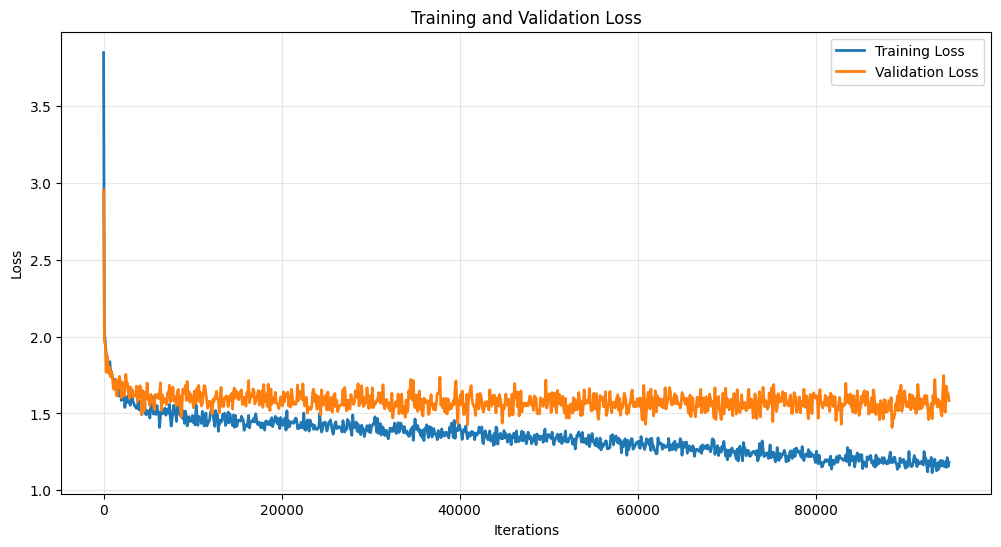

In [29]:
if len(lossi) > 0:
    plt.figure(figsize=(12, 6))
    # Average losses over 100 iterations for smoother plot
    if len(lossi) % 100 == 0:
        train_loss_smooth = torch.tensor(lossi).view(-1, 100).mean(1)
    else:
        train_loss_smooth = torch.tensor(lossi)
    if len(val_lossi) % 100 == 0:
        val_loss_smooth = torch.tensor(val_lossi).view(-1, 100).mean(1)
    else:
        val_loss_smooth = torch.tensor(val_lossi)
    
    iterations = torch.arange(len(train_loss_smooth)) * 100
    plt.plot(iterations, train_loss_smooth, label='Training Loss', linewidth=2)
    plt.plot(iterations, val_loss_smooth, label='Validation Loss', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [32]:
idx = torch.zeros((1, block_size), dtype=torch.long, device=device)
logits, _ = model(idx)
logits = logits[:, -1, :]
probs = F.softmax(logits, dim=-1)  # (1, vocab_size)
idx_next = torch.multinomial(probs, num_samples=1, generator=g)  # (1, 1)
idx_next

tensor([[0]], device='cuda:0')

In [39]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 22)

def generate(model):
    # Generate one sequence at a time, stop if 0 is predicted
    idx = torch.zeros((1, block_size - 1), dtype=torch.long, device=device)
    idx = torch.randint(1, vocab_size, (1, 1), device=device)
    out = []
    for i in range(25):
        logits, _ = model(idx)
        logits = logits[:, -1, :]  # (1, vocab_size)
        probs = F.softmax(logits, dim=-1)  # (1, vocab_size)
        idx_next = torch.multinomial(probs, num_samples=1, generator=g)  # (1, 1)
        next_token = idx_next.item()
        out.append(next_token)
        # Shift context window: drop first token, append new token
        idx = torch.cat([idx[:, 1:], idx_next], dim=1)  # (1, block_size)
       # print(next_token)
        if next_token == 0:
            break
    return out

for _ in range(25):
    out = generate(model)
    print(''.join(itos[i] for i in out if i != 0))  # print string up to but not including 0


'ht

-j-r

'
hrt
j
i'
yhr
-j'

ujk'
-u
'
j
'jk

r'jej
j
j'''bkr
em
 ka-hu''jjr
jbrj
jrl ja


In [36]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 22)

def generate(model):
    # Generate one sequence at a time, stop if 0 is predicted
    idx = torch.zeros((1, block_size), dtype=torch.long, device=device)
    out = [idx]
    for i in range(25):
        logits, _ = model(idx)
        logits = logits[:, -1, :]  # (1, vocab_size)
        probs = F.softmax(logits, dim=-1)  # (1, vocab_size)
        idx_next = torch.multinomial(probs, num_samples=1, generator=g)  # (1, 1)
        next_token = idx_next.item()
        out.append(next_token)
        # Shift context window: drop first token, append new token
        idx = torch.cat([idx[:, 1:], idx_next], dim=1)  # (1, block_size)
       # print(next_token)
    return out

for _ in range(25):
    out = generate(model)
    print(''.join(itos[i] for i in out if i != 0))  # print string up to but not including 0

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [34]:
# sample from the model forcing more words
g = torch.Generator(device=device).manual_seed(2147483647 + 69)

for _ in range(25):
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

NameError: name 'C' is not defined

In [ ]:
# sample from the model forcing "the"
g = torch.Generator(device=device).manual_seed(2147483647 + 67)

for _ in range(25):
    has_the = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if ix == 0:
        if has_the==False:
            context = context[5:] + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
            has_the = True
            out = out[5:] + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
        else:
            break
      else:
        context = context[1:] + [ix]
        out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
print(out)
out[4:] + [stoi['t'], stoi['h'], stoi['e'], stoi[' ']]

In [ ]:
stoi

In [ ]:
C.shape

### from andrejs
train 2.0193495750427246
val 2.156538963317871
### bigger network
train 1.9244529008865356
val 2.1407828330993652
### adjusted sizes + more data
train 1.642111897468567
val 2.2296860218048096

good names tho